In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Loading the Dataset

In [88]:
df = pd.read_csv('data/xor.csv')
df

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


In [89]:
X = df[['x1', 'x2']].values
y = df['class label'].values

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1, stratify = y)

In [91]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 1, stratify = y_train)

In [92]:
print('X_train.shape =', X_train.shape)
print('X_val.shape =', X_val.shape)
print('X_test.shape =', X_test.shape)

X_train.shape = (573, 2)
X_val.shape = (64, 2)
X_test.shape = (113, 2)


In [93]:
print('Training labels:', np.bincount(y_train))
print('Validation labels:', np.bincount(y_val))
print('Test labels:', np.bincount(y_test))

Training labels: [287 286]
Validation labels: [32 32]
Test labels: [57 56]


# Visualize the data

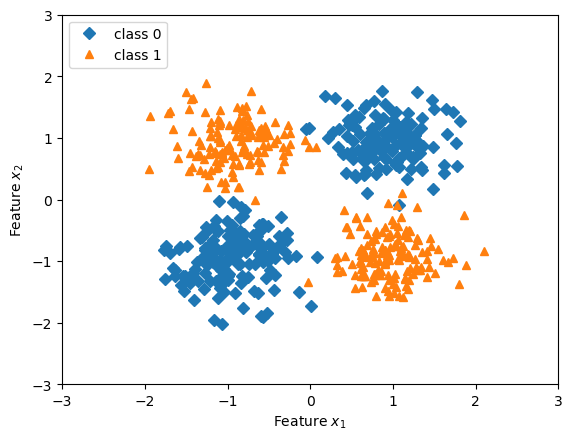

In [94]:
plt.plot(
    X_train[y_train == 0, 0], X_train[y_train == 0, 1],
    marker = 'D', markersize = 6, label = 'class 0', linestyle = ''
)

plt.plot(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1],
    marker = '^', markersize = 6, label = 'class 1', linestyle = ''
)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature $x_1$')
plt.ylabel('Feature $x_2$')
plt.legend(loc = 'upper left')
plt.show()

As we can see to classes are not linearly separable so Logistic Regression will not work here. We need to use a non-linear model.

# Implementing the model

In [95]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, num_feautures, num_classes):
        super().__init__()
        self.all_layers = nn.Sequential(
            # 1st hidden layer
            nn.Linear(num_feautures, 25),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(25, 15),
            nn.ReLU(),

            # Output layer
            nn.Linear(15, num_classes)
        )
    
    def forward(self, x):
        return self.all_layers(x)

# Defining the Dataset, DataLoader

In [96]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.feautures = torch.tensor(X, dtype = torch.float32)
        self.labels = torch.tensor(y, dtype = torch.int64)
    
    def __getitem__(self, index):
        return self.feautures[index], self.labels[index]
    
    def __len__(self):
        return len(self.labels)
    
train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(
    train_ds, batch_size = 32, shuffle = True
)

val_loader = DataLoader(
    val_ds, batch_size = 32, shuffle = False
)

test_loader = DataLoader(
    test_ds, batch_size = 32, shuffle = False
)

# Training loop

In [97]:
def compute_accuracy(model, data_loader):
    model.eval()

    correct_pred, num_examples = 0, 0

    for features, labels in data_loader:
        with torch.no_grad():
            logits = model(features)
        
        predictions = torch.argmax(logits, dim = 1)
        correct_pred += torch.sum(predictions == labels)
        num_examples += len(labels)
    
    return correct_pred / num_examples

In [98]:
torch.manual_seed(1)

learning_rate = 0.05
num_epochs = 10

model = MultilayerPerceptron(num_feautures = 2, num_classes = 2)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

best_train_acc = 0.0
best_val_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (features, labels) in enumerate(train_loader):
        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
              f" | Train/Val Loss: {loss:.2f}")
    
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_train_acc = train_acc
        best_epoch = epoch + 1

    print(f"Epoch: {epoch+1:04d}/{num_epochs:04d}", 'Train Acc: %.4f' % train_acc, 'Val Acc: %.4f' % val_acc)

Epoch: 001/010 | Batch 000/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 001/018 | Train/Val Loss: 0.69
Epoch: 001/010 | Batch 002/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 003/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 004/018 | Train/Val Loss: 0.69
Epoch: 001/010 | Batch 005/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 006/018 | Train/Val Loss: 0.66
Epoch: 001/010 | Batch 007/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 008/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 009/018 | Train/Val Loss: 0.68
Epoch: 001/010 | Batch 010/018 | Train/Val Loss: 0.66
Epoch: 001/010 | Batch 011/018 | Train/Val Loss: 0.65
Epoch: 001/010 | Batch 012/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 013/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 014/018 | Train/Val Loss: 0.65
Epoch: 001/010 | Batch 015/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 016/018 | Train/Val Loss: 0.67
Epoch: 001/010 | Batch 017/018 | Train/Val Loss: 0.65
Epoch: 0001/0010 Train Acc: 

In [99]:
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Training accuracy of that best: {best_train_acc*100:.2f}%")
print(f"Number of Epochs enough: {best_epoch}")

Best validation accuracy: 100.00%
Training accuracy of that best: 97.03%
Number of Epochs enough: 8


# Evaluation

In [100]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train accuracy: {train_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")
print(f"Test accuracy: {test_acc*100:.2f}%")

Train accuracy: 98.25%
Validation accuracy: 100.00%
Test accuracy: 99.12%


In [101]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('D', '^', 'x', 's', 'v')
    colors = ('C0', 'C1', 'C2', 'C3', 'C4')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    Z = np.argmax(logits.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    #edgecolor='black',
                    marker=markers[idx], 
                    label=cl)   
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Regions')

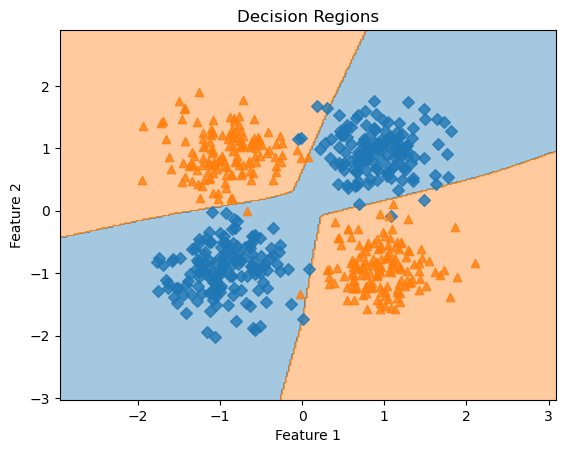

In [102]:
plot_decision_regions(X_train, y_train, classifier=model)